# 🌊 SDSS Flood Prediction ML System

This notebook contains the complete machine learning pipeline for flood prediction in the Smart Decision Support System (SDSS).

## 📋 Table of Contents
1. [Setup and Imports](#setup)
2. [Data Generation](#data-generation)
3. [Data Exploration](#data-exploration)
4. [Model Training](#model-training)
5. [Model Evaluation](#model-evaluation)
6. [Feature Analysis](#feature-analysis)
7. [Predictions and Visualization](#predictions)
8. [Model Deployment](#deployment)

---


## 1. Setup and Imports {#setup}


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📊 NumPy version: {np.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")
print(f"🎨 Seaborn version: {sns.__version__}")


✅ All libraries imported successfully!
📊 NumPy version: 2.3.3
🐼 Pandas version: 2.3.2
📈 Matplotlib version: 3.10.6
🎨 Seaborn version: 0.13.2


## 2. Data Generation {#data-generation}


In [2]:
def generate_flood_dataset(n_samples=10000, seed=42):
    """
    Generate synthetic but realistic flood prediction dataset
    """
    np.random.seed(seed)
    
    data = []
    for i in range(n_samples):
        # Base environmental factors
        temperature = np.random.normal(25, 8)  # 25°C ± 8°C
        humidity = np.random.normal(65, 20)    # 65% ± 20%
        pressure = np.random.normal(1013, 20)  # 1013 hPa ± 20
        
        # Seasonal patterns
        day_of_year = np.random.randint(1, 365)
        seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * day_of_year / 365)
        
        # Historical rainfall (last 7 days)
        rainfall_7d = np.random.exponential(2) * seasonal_factor
        rainfall_24h = np.random.exponential(1) * seasonal_factor
        
        # River level (depends on rainfall and other factors)
        base_river_level = 2.0
        river_level = base_river_level + (rainfall_7d * 0.1) + np.random.normal(0, 0.3)
        
        # Soil moisture (depends on rainfall and temperature)
        soil_moisture = min(1.0, max(0.0, 0.3 + (rainfall_7d * 0.05) - (temperature - 25) * 0.01))
        
        # Wind speed and direction
        wind_speed = np.random.exponential(3)
        wind_direction = np.random.uniform(0, 360)
        
        # Calculate flood risk based on multiple factors
        risk_factors = {
            'rainfall_factor': min(1.0, rainfall_24h / 50),
            'river_factor': min(1.0, max(0, river_level - 2) / 3),
            'soil_factor': soil_moisture,
            'temperature_factor': max(0, (temperature - 30) / 10),
            'humidity_factor': humidity / 100,
            'pressure_factor': abs(pressure - 1013) / 50,
        }
        
        # Weighted flood risk calculation
        flood_risk = (
            0.4 * risk_factors['rainfall_factor'] +
            0.3 * risk_factors['river_factor'] +
            0.15 * risk_factors['soil_factor'] +
            0.1 * risk_factors['temperature_factor'] +
            0.05 * risk_factors['humidity_factor']
        )
        
        # Add some noise and ensure 0-1 range
        flood_risk = min(1.0, max(0.0, flood_risk + np.random.normal(0, 0.1)))
        
        # Determine flood level
        if flood_risk > 0.8:
            flood_level = "EMERGENCY"
        elif flood_risk > 0.6:
            flood_level = "WARNING"
        elif flood_risk > 0.4:
            flood_level = "WATCH"
        else:
            flood_level = "INFO"
        
        data.append({
            'temperature': temperature,
            'humidity': humidity,
            'pressure': pressure,
            'rainfall_24h': rainfall_24h,
            'rainfall_7d': rainfall_7d,
            'river_level': river_level,
            'soil_moisture': soil_moisture,
            'wind_speed': wind_speed,
            'wind_direction': wind_direction,
            'day_of_year': day_of_year,
            'flood_risk': flood_risk,
            'flood_level': flood_level
        })
    
    return pd.DataFrame(data)

# Generate the dataset
print("🌊 Generating flood prediction dataset...")
df = generate_flood_dataset(n_samples=10000)
print(f"✅ Dataset generated with {len(df)} samples")
print(f"📊 Dataset shape: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")


🌊 Generating flood prediction dataset...
✅ Dataset generated with 10000 samples
📊 Dataset shape: (10000, 12)
📋 Columns: ['temperature', 'humidity', 'pressure', 'rainfall_24h', 'rainfall_7d', 'river_level', 'soil_moisture', 'wind_speed', 'wind_direction', 'day_of_year', 'flood_risk', 'flood_level']


## 3. Data Exploration {#data-exploration}


In [3]:
# Basic dataset information
print("📊 Dataset Overview")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

print("📋 Basic Statistics")
print("=" * 50)
print(df.describe().round(3))
print()

print("🎯 Target Variable Distribution")
print("=" * 50)
print(df['flood_level'].value_counts())
print(f"\nFlood Risk Range: {df['flood_risk'].min():.3f} - {df['flood_risk'].max():.3f}")
print(f"Mean Flood Risk: {df['flood_risk'].mean():.3f}")
print(f"Std Flood Risk: {df['flood_risk'].std():.3f}")


📊 Dataset Overview
Shape: (10000, 12)
Memory usage: 1.34 MB

📋 Basic Statistics
       temperature   humidity   pressure  rainfall_24h  rainfall_7d  \
count    10000.000  10000.000  10000.000     10000.000    10000.000   
mean        24.972     65.104   1012.959         0.986        2.025   
std          8.054     20.332     19.846         1.038        2.145   
min         -2.841    -12.128    939.229         0.000        0.000   
25%         19.502     51.382    999.589         0.266        0.552   
50%         24.960     65.110   1012.968         0.655        1.355   
75%         30.376     78.996   1026.106         1.349        2.746   
max         55.454    138.181   1091.847        10.606       25.853   

       river_level  soil_moisture  wind_speed  wind_direction  day_of_year  \
count    10000.000      10000.000   10000.000       10000.000    10000.000   
mean         2.202          0.401       3.025         179.345      182.985   
std          0.362          0.132       3.026 

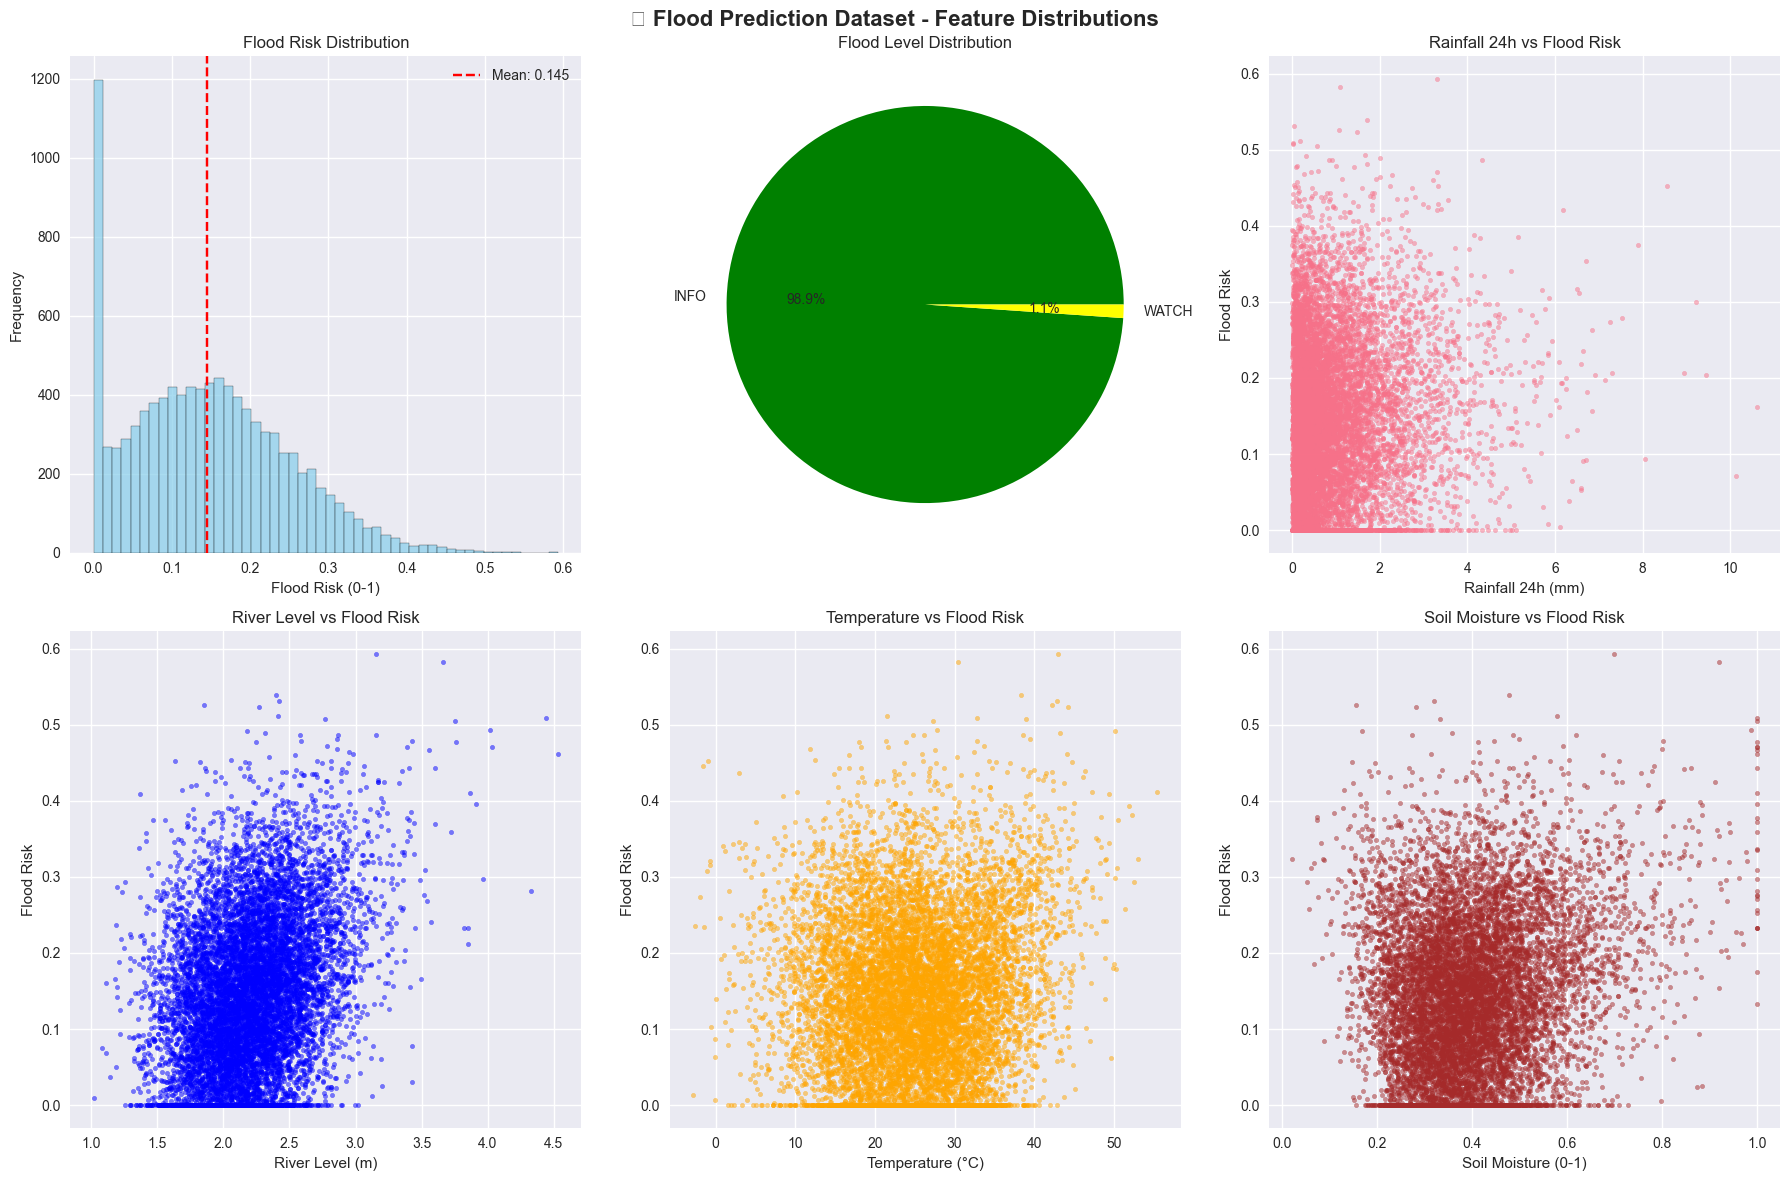

In [4]:
# Visualize the dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🌊 Flood Prediction Dataset - Feature Distributions', fontsize=16, fontweight='bold')

# Plot 1: Flood risk distribution
axes[0, 0].hist(df['flood_risk'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Flood Risk Distribution')
axes[0, 0].set_xlabel('Flood Risk (0-1)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['flood_risk'].mean(), color='red', linestyle='--', label=f'Mean: {df["flood_risk"].mean():.3f}')
axes[0, 0].legend()

# Plot 2: Flood level distribution
flood_counts = df['flood_level'].value_counts()
colors = ['green', 'yellow', 'orange', 'red']
axes[0, 1].pie(flood_counts.values, labels=flood_counts.index, autopct='%1.1f%%', colors=colors)
axes[0, 1].set_title('Flood Level Distribution')

# Plot 3: Rainfall vs Flood Risk
axes[0, 2].scatter(df['rainfall_24h'], df['flood_risk'], alpha=0.5, s=10)
axes[0, 2].set_title('Rainfall 24h vs Flood Risk')
axes[0, 2].set_xlabel('Rainfall 24h (mm)')
axes[0, 2].set_ylabel('Flood Risk')

# Plot 4: River Level vs Flood Risk
axes[1, 0].scatter(df['river_level'], df['flood_risk'], alpha=0.5, s=10, color='blue')
axes[1, 0].set_title('River Level vs Flood Risk')
axes[1, 0].set_xlabel('River Level (m)')
axes[1, 0].set_ylabel('Flood Risk')

# Plot 5: Temperature vs Flood Risk
axes[1, 1].scatter(df['temperature'], df['flood_risk'], alpha=0.5, s=10, color='orange')
axes[1, 1].set_title('Temperature vs Flood Risk')
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('Flood Risk')

# Plot 6: Soil Moisture vs Flood Risk
axes[1, 2].scatter(df['soil_moisture'], df['flood_risk'], alpha=0.5, s=10, color='brown')
axes[1, 2].set_title('Soil Moisture vs Flood Risk')
axes[1, 2].set_xlabel('Soil Moisture (0-1)')
axes[1, 2].set_ylabel('Flood Risk')

plt.tight_layout()
plt.show()


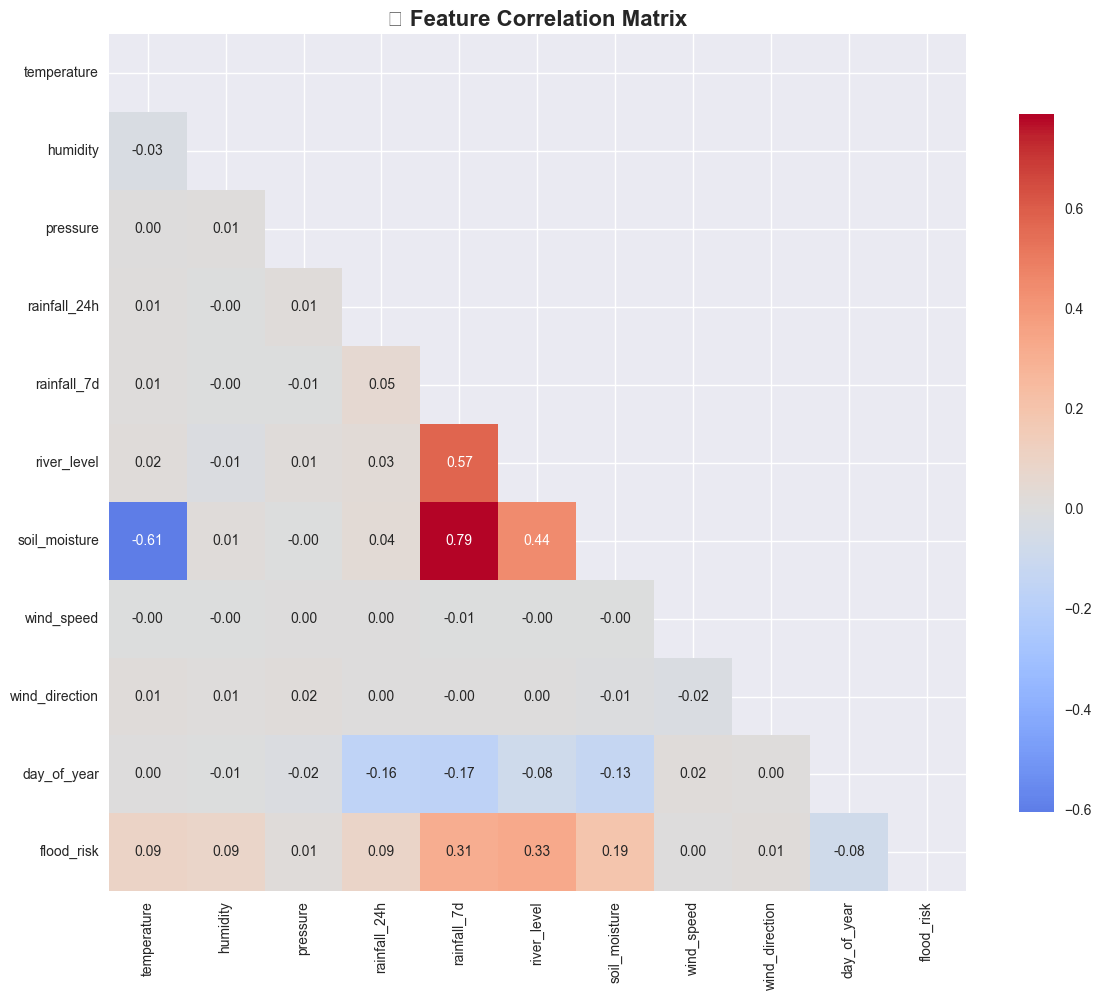

🔍 Top Correlations with Flood Risk:
river_level         : 0.326
rainfall_7d         : 0.313
soil_moisture       : 0.192
temperature         : 0.092
rainfall_24h        : 0.089
humidity            : 0.086
day_of_year         : 0.076
wind_direction      : 0.012
pressure            : 0.011
wind_speed          : 0.003


In [5]:
# Correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('🌊 Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show top correlations with flood risk
flood_correlations = correlation_matrix['flood_risk'].abs().sort_values(ascending=False)
print("🔍 Top Correlations with Flood Risk:")
print("=" * 40)
for feature, corr in flood_correlations.items():
    if feature != 'flood_risk':
        print(f"{feature:20s}: {corr:.3f}")


## 4. Model Training {#model-training}


In [6]:
# Prepare features and target
feature_columns = [
    'temperature', 'humidity', 'pressure', 'rainfall_24h', 'rainfall_7d',
    'river_level', 'soil_moisture', 'wind_speed', 'wind_direction', 'day_of_year'
]

X = df[feature_columns]
y = df['flood_risk']

print("🎯 Feature Preparation")
print("=" * 30)
print(f"Features: {feature_columns}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Target range: {y.min():.3f} - {y.max():.3f}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=4, labels=False)
)

print(f"\n📊 Train/Test Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training ratio: {X_train.shape[0] / len(df):.1%}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n🔧 Feature Scaling Applied")
print(f"Scaled training shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")


🎯 Feature Preparation
Features: ['temperature', 'humidity', 'pressure', 'rainfall_24h', 'rainfall_7d', 'river_level', 'soil_moisture', 'wind_speed', 'wind_direction', 'day_of_year']
X shape: (10000, 10)
y shape: (10000,)
Target range: 0.000 - 0.593

📊 Train/Test Split:
Training set: 8000 samples
Test set: 2000 samples
Training ratio: 80.0%

🔧 Feature Scaling Applied
Scaled training shape: (8000, 10)
Scaled test shape: (2000, 10)


In [7]:
# Train multiple models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}

model_results = {}

print("🚀 Training Models")
print("=" * 50)

for name, model in models.items():
    print(f"\n📈 Training {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    # Store results
    model_results[name] = {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test
    }
    
    print(f"✅ {name} Training Complete")
    print(f"   Train R²: {train_r2:.4f}")
    print(f"   Test R²:  {test_r2:.4f}")
    print(f"   CV R²:    {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"   Test MSE: {test_mse:.4f}")
    print(f"   Test MAE: {test_mae:.4f}")

# Select best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_r2'])
best_model = model_results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R²: {model_results[best_model_name]['test_r2']:.4f}")
print(f"   Test MSE: {model_results[best_model_name]['test_mse']:.4f}")


🚀 Training Models

📈 Training Random Forest...
✅ Random Forest Training Complete
   Train R²: 0.8821
   Test R²:  0.1676
   CV R²:    0.1508 ± 0.0300
   Test MSE: 0.0082
   Test MAE: 0.0738

📈 Training Gradient Boosting...
✅ Gradient Boosting Training Complete
   Train R²: 0.4790
   Test R²:  0.1601
   CV R²:    0.1502 ± 0.0298
   Test MSE: 0.0083
   Test MAE: 0.0740

🏆 Best Model: Random Forest
   Test R²: 0.1676
   Test MSE: 0.0082


## 5. Model Evaluation {#model-evaluation}


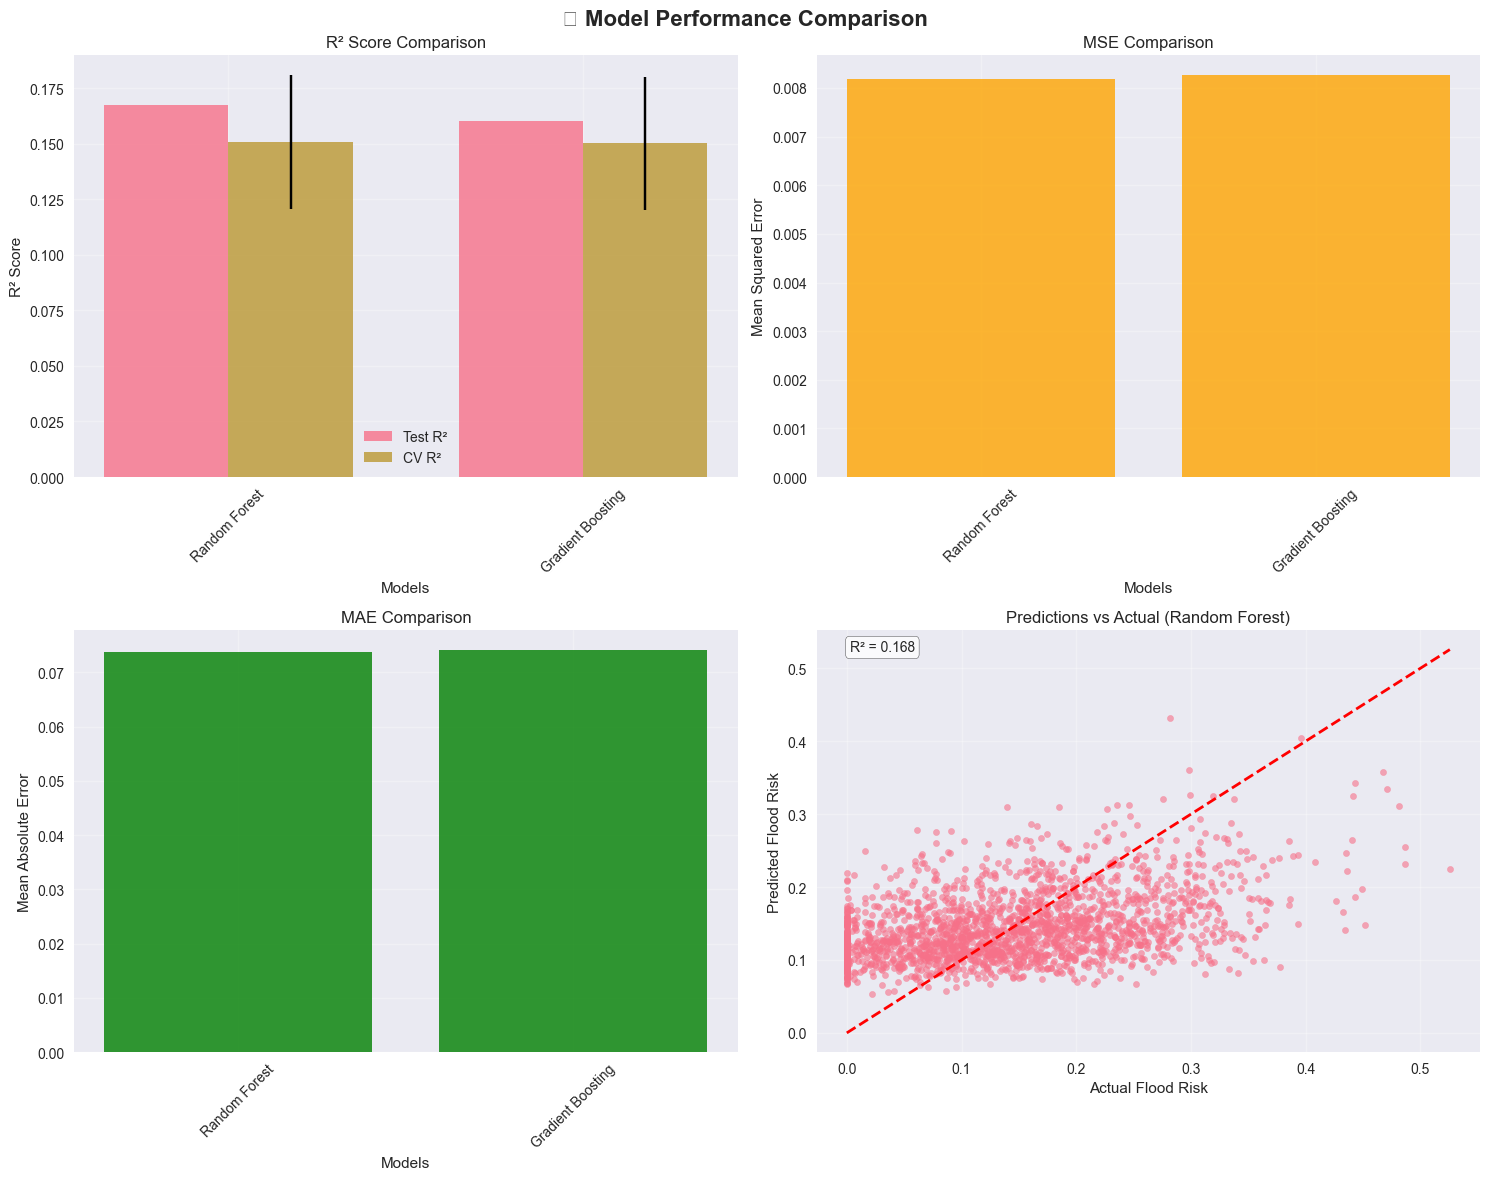

📊 Detailed Model Results

🔍 Random Forest:
   Test R²:    0.1676
   Test MSE:   0.0082
   Test MAE:   0.0738
   CV R²:      0.1508 ± 0.0300
   Train R²:   0.8821
   Overfitting: 0.7145

🔍 Gradient Boosting:
   Test R²:    0.1601
   Test MSE:   0.0083
   Test MAE:   0.0740
   CV R²:      0.1502 ± 0.0298
   Train R²:   0.4790
   Overfitting: 0.3189


In [8]:
# Model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🌊 Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. R² Score Comparison
model_names = list(model_results.keys())
r2_scores = [model_results[name]['test_r2'] for name in model_names]
cv_means = [model_results[name]['cv_mean'] for name in model_names]
cv_stds = [model_results[name]['cv_std'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, r2_scores, width, label='Test R²', alpha=0.8)
axes[0, 0].bar(x + width/2, cv_means, width, yerr=cv_stds, label='CV R²', alpha=0.8, capsize=5)
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. MSE Comparison
mse_scores = [model_results[name]['test_mse'] for name in model_names]
axes[0, 1].bar(model_names, mse_scores, alpha=0.8, color='orange')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Mean Squared Error')
axes[0, 1].set_title('MSE Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. MAE Comparison
mae_scores = [model_results[name]['test_mae'] for name in model_names]
axes[1, 0].bar(model_names, mae_scores, alpha=0.8, color='green')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('Mean Absolute Error')
axes[1, 0].set_title('MAE Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 4. Predictions vs Actual (Best Model)
best_predictions = model_results[best_model_name]['predictions']
axes[1, 1].scatter(y_test, best_predictions, alpha=0.6, s=20)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Flood Risk')
axes[1, 1].set_ylabel('Predicted Flood Risk')
axes[1, 1].set_title(f'Predictions vs Actual ({best_model_name})')
axes[1, 1].grid(True, alpha=0.3)

# Add R² score to the plot
r2_best = model_results[best_model_name]['test_r2']
axes[1, 1].text(0.05, 0.95, f'R² = {r2_best:.3f}', transform=axes[1, 1].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed results
print("📊 Detailed Model Results")
print("=" * 60)
for name, results in model_results.items():
    print(f"\n🔍 {name}:")
    print(f"   Test R²:    {results['test_r2']:.4f}")
    print(f"   Test MSE:   {results['test_mse']:.4f}")
    print(f"   Test MAE:   {results['test_mae']:.4f}")
    print(f"   CV R²:      {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")
    print(f"   Train R²:   {results['train_r2']:.4f}")
    print(f"   Overfitting: {results['train_r2'] - results['test_r2']:.4f}")


## 6. Feature Analysis {#feature-analysis}


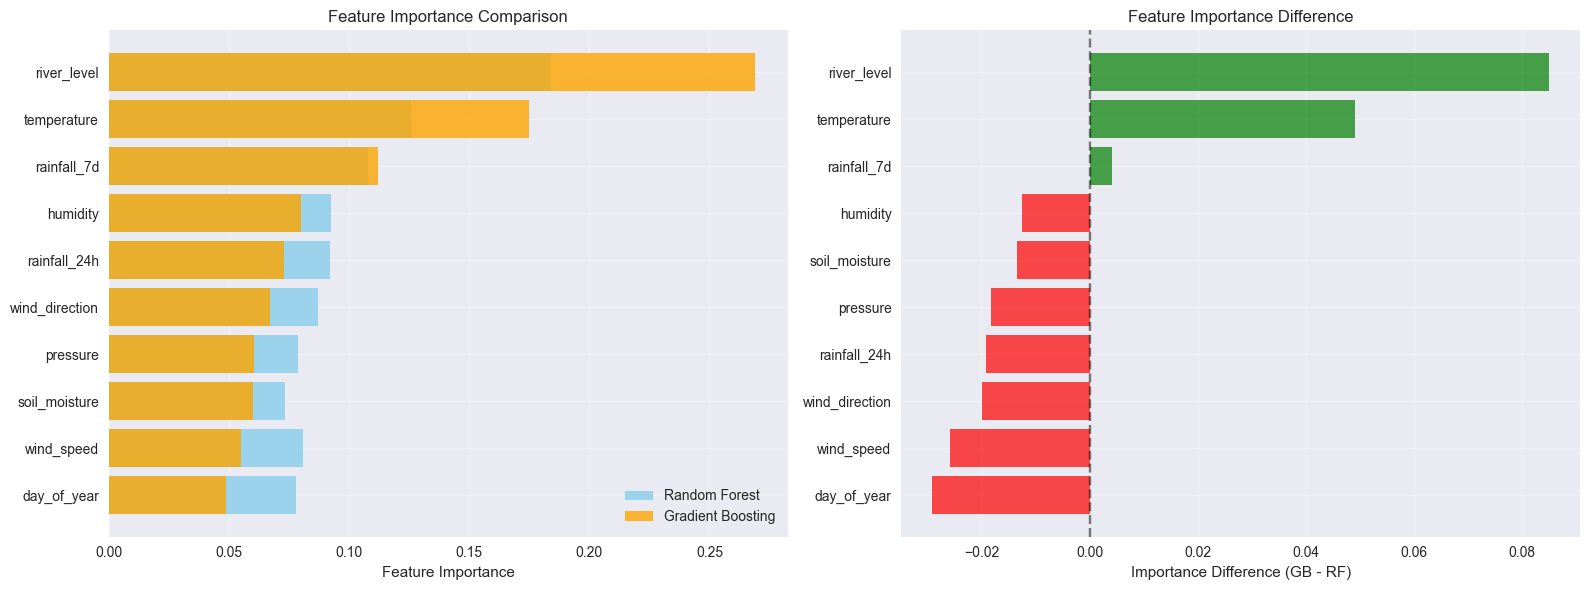

🔍 Feature Importance Rankings

📊 Gradient Boosting (Best Model):
 1. river_level         : 0.2690
 2. temperature         : 0.1749
 3. rainfall_7d         : 0.1121
 4. humidity            : 0.0800
 5. rainfall_24h        : 0.0728
 6. wind_direction      : 0.0671
 7. pressure            : 0.0604
 8. soil_moisture       : 0.0601
 9. wind_speed          : 0.0549
10. day_of_year         : 0.0488

📈 Top 5 Most Important Features:
1. river_level: 0.2690
2. temperature: 0.1749
3. rainfall_7d: 0.1121
4. humidity: 0.0800
5. rainfall_24h: 0.0728


In [9]:
# Feature importance analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get feature importance from both models
rf_importance = model_results['Random Forest']['model'].feature_importances_
gb_importance = model_results['Gradient Boosting']['model'].feature_importances_

# Create feature importance DataFrames
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Random Forest': rf_importance,
    'Gradient Boosting': gb_importance
}).sort_values('Gradient Boosting', ascending=True)

# Plot feature importance
y_pos = np.arange(len(importance_df))
axes[0].barh(y_pos, importance_df['Random Forest'], alpha=0.8, label='Random Forest', color='skyblue')
axes[0].barh(y_pos, importance_df['Gradient Boosting'], alpha=0.8, label='Gradient Boosting', color='orange')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(importance_df['Feature'])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Feature Importance Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Feature importance difference
importance_df['Difference'] = importance_df['Gradient Boosting'] - importance_df['Random Forest']
importance_df = importance_df.sort_values('Difference', ascending=True)

axes[1].barh(range(len(importance_df)), importance_df['Difference'], 
             color=['red' if x < 0 else 'green' for x in importance_df['Difference']], alpha=0.7)
axes[1].set_yticks(range(len(importance_df)))
axes[1].set_yticklabels(importance_df['Feature'])
axes[1].set_xlabel('Importance Difference (GB - RF)')
axes[1].set_title('Feature Importance Difference')
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print feature importance rankings
print("🔍 Feature Importance Rankings")
print("=" * 50)
print("\n📊 Gradient Boosting (Best Model):")
gb_ranking = importance_df.sort_values('Gradient Boosting', ascending=False)
for i, (_, row) in enumerate(gb_ranking.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:20s}: {row['Gradient Boosting']:.4f}")

print(f"\n📈 Top 5 Most Important Features:")
for i, (_, row) in enumerate(gb_ranking.head().iterrows(), 1):
    print(f"{i}. {row['Feature']}: {row['Gradient Boosting']:.4f}")
